# Overview

1. $H_t(z) := \int_{0}^{\infty}e^{tu^2}\phi (u) \cos (zu) du$
2. $\Phi (u) := \sum_{n=1}^{\infty} (2 \pi^2n^4 e^{9u} - 3 \pi n^2 e^{5u}) \exp{(-\pi n^2 e^{4u})}$
3. The equations above describe the heatflow of the Riemann Equation.
4. $\exists Λ \in \mathbb{R}$ such that $\forall t \geq Λ$, we have the zeroes of ${H_t}$ being real. This is known as the [de Bruijn–Newman constant](https://en.wikipedia.org/wiki/De_Bruijn%E2%80%93Newman_constant).
5. $Λ \geq 0$ was [proved](https://arxiv.org/pdf/1801.05914.pdf) by Brad Rogers & Terence Tau.
6. $Λ > 0$ is equivalent to the Riemann Hypothesis.
7. $Λ \leq .22$ was [proved](https://github.com/km-git-acc/dbn_upper_bound/blob/master/Writeup/debruijn.pdf) as part of the polimath project.
8. $H_0(z) = \int_0^{\infty}\phi (u) cos(zu) du$ is the Fourier representation of $H_0(z)$

We want to find bounds on $Λ$, following an approach similar to the polymath project

# Plan to bound $Λ$

1. Choose a $t \geq Λ$ ( $t>.2$ suffices for the time being )
2. Take $n$ zeroes $(x_1, x_2, \dots , x_n)$ of $H_t$
3. Computationally estimate how the $x_i$ evolve backwards in time (i.e. towards $t=0$, getting an estimate of the time $t_k$ at which the trajectories of the various $x_i$ converge to a single point
4. Reproduce the above with higher values for $n$, obtaining iteratively better estimates of $Λ$.
5. If
   1. $G \approx 0$, we proved nothing 😢.
   2. $G$ is statistically far from $0$, we have shown that Riemann's Hypothesis is likely true 🎉
  
# Pre-requisites
1. Do we have examples ( in code or books ) of approximating path trajectories using heatflow?
2. What are the best methods known to find zeroes of the Riemann Zeta, i.e. the $(x_1, x_2, ... , x_n)$

# Visualizing $H_t$

We approximate $H_t$ by adding more terms to the sum and approximating the integral. Since the exponential in the integral decreases much faster than the $\Phi$ terms, we can approximate the integral.

We will define a function $h(t,u,z,k)=e^{tu^2} \left [ \sum_{n=1}^{k} (2 \pi^2n^4 e^{9u} - 3 \pi n^2 e^{5u}) \exp{(-\pi n^2 e^{4u})} \right ] \cos (zu)$, and then approximate the integral over $u$ using QUADPACK

1. $H_t(z) := \int_{0}^{\infty}e^{tu^2}\phi (u) \cos (zu) du$
2. $\Phi (u) := \sum_{n=1}^{\infty} (2 \pi^2n^4 e^{9u} - 3 \pi n^2 e^{5u}) \exp{(-\pi n^2 e^{4u})}$

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot
from scipy.integrate import quad # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad
import itertools

In [2]:
def h(t, u, z, k):
    return np.product([
        math.exp(t*u**2),
        np.sum([
            (2*math.pi**2*n**4*math.exp(9*u)-3*math.pi*n**2*math.exp(5*u))*math.exp(-1*math.pi*n**2*math.exp(4*u))
            for n in range(1, k+1)
        ]),
        math.cos(z*u)
    ])

def H(t,z,k,b):
    function = lambda u: h(t,u,z,k)
    return quad(
        func=function,
        a=0,
        b=b
    )

## Building the relevant data

In [3]:
k_array = [100]
b_array = [16] # [2**i for i in range(5)]
z_array = np.divide(range(-10000,10000), 100)
total = len(k_array) * len(b_array) * len(z_array)

df = pd.DataFrame([
    {
        "k": k,
        "b":b,
        "z": z,
        "h": H(t=1, z=z, k=k, b=b)[0],
        "error": H(t=1, z=z, k=k, b=b)[1],
    }
    for k, b, z in tqdm(
        itertools.product(k_array, b_array, z_array),
        total=np.product(total)
    )
])
df["logerror"] = [math.log(e, 10) for e in df["error"]]
df["sign"] = [np.sign(h) for h in df["h"]]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [4]:
df.head()

,k,b,z,h,error,logerror,sign
0,100,16,-100.00,8.597207e-16,2.632662e-09,-8.579605,1.0
1,100,16,-99.99,8.673558e-16,2.639797e-09,-8.578430,1.0
2,100,16,-99.98,8.762153e-16,2.646870e-09,-8.577267,1.0
3,100,16,-99.97,8.858728e-16,2.653881e-09,-8.576119,1.0
4,100,16,-99.96,8.963722e-16,2.660830e-09,-8.574983,1.0


## $H_{0.22}(z)$ looks normally distributed around zero

<Axes: xlabel='z', ylabel='h'>

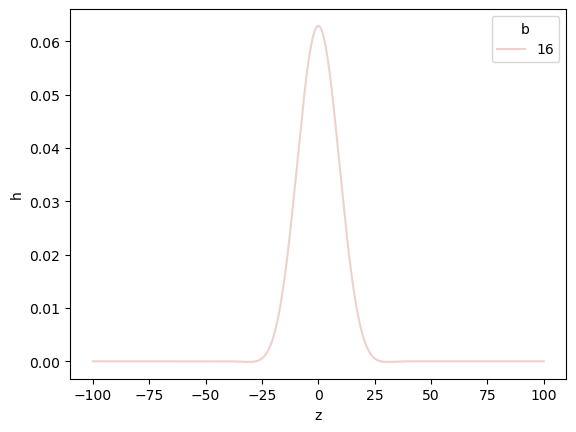

In [5]:
sns.lineplot(
    x="z",
    y="h",
    hue="b",
    data=df[df["b"]==16]
)

## Visualizing the sign of $h$

- The location of zeroes become easier to observe: we have a zero whenever the sign of $h$ swaps, as seen below.
- The zeroes are not clear from the image above.

<Axes: xlabel='z', ylabel='sign'>

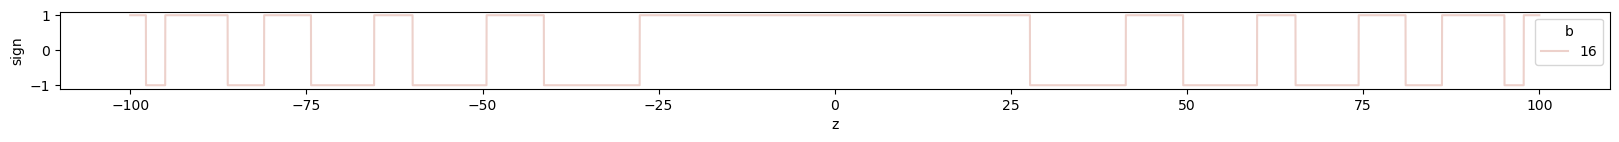

In [6]:
fig, ax = pyplot.subplots(figsize=(20,1))
sns.lineplot(
    x="z",
    y="sign",
    hue="b",
    data=df[df["b"]==16],
    ax=ax
)

The zeroes above are unreliable: we calculated this function using a small $k$ and integrating $h$ only on $\int_0^{b}$ . They are merely a starting point for finding the zeroes